# Setup

In [95]:
!pip install fastai==2.7.10
!pip install git+https://github.com/lessw2020/Ranger21.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lessw2020/Ranger21.git to /tmp/pip-req-build-_vogkgs0
  Running command git clone -q https://github.com/lessw2020/Ranger21.git /tmp/pip-req-build-_vogkgs0


Getting Data in Drive

In [96]:
from google.colab import drive

#you will have to change this for your own folder
drive.mount('/content/drive')
%cd /content/drive/My Drive/MACHINE LEARNING - Masters/project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MACHINE LEARNING - Masters/project


# Processing training data

In [97]:
from os import listdir

def remove_invalid(df):
    file_names = listdir('data/images')
    return df[df['image_id'].isin(file_names)]

In [98]:
from fastai.vision.all import *
import pandas as pd

train_df = pd.read_csv('data/train.csv')
train_df = remove_invalid(train_df)

train_db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter=TrainTestSplitter(),
                    get_x=ColReader(0, pref="data/images/"),
                    get_y=ColReader(1, label_delim=' '),
                    item_tfms=Resize(400),
                    batch_tfms=aug_transforms())
print(train_db)
print(train_df)
dls = train_db.dataloaders(train_df)

       image_id                 labels
0    img256.jpg    l16 l18 l23 l25 l73
1     img98.jpg         l0 l24 l26 l39
2    img147.jpg                 l14 l3
3    img254.jpg             l2 l25 l29
4    img160.jpg      l0 l32 l38 l40 l6
..          ...                    ...
200  img105.jpg                    l51
201  img198.jpg      l0 l10 l11 l65 l7
202   img82.jpg                     l2
203  img124.jpg   l0 l1 l19 l22 l34 l6
204   img23.jpg  l1 l15 l18 l2 l21 l71

[200 rows x 2 columns]


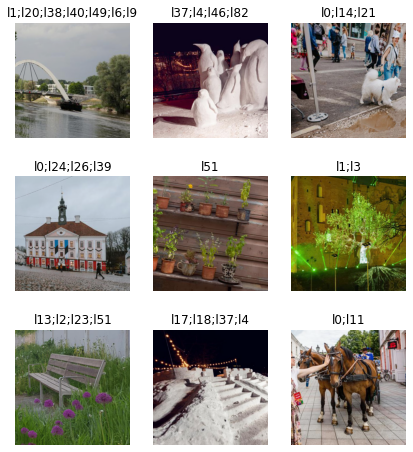

In [99]:
dls.show_batch(max_n=9, figsize=(7,8))

# The good stuff

In [100]:
# https://forums.fast.ai/t/what-s-your-go-to-optimizer-in-2021/87532/10
from ranger21 import Ranger21

def ranger21(params, lr, **kwargs):
    return OptimWrapper(params, Ranger21, lr=lr, 
                        num_epochs=10,
                        num_batches_per_epoch=len(dls.train),
                        **kwargs)

In [101]:
class ResBlock(Module):
  def __init__(self, nf):
    self.conv1 = ConvLayer(nf, nf)
    self.conv2 = ConvLayer(nf, nf)
  
  def forward(self, x): return x + self.conv2(self.conv1(x))

In [102]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

In [108]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [125]:
def get_model(model, pretrained=False, progress=True, **kwargs):
    """model: function to load the model, e.g. resnet18
        pretrained, progress: to be passed to the model function
    """
    m = model(pretrained=pretrained, progress=progress, **kwargs) # loads standard model
    m.avgpool = nn.AdaptiveAvgPool2d(output_size=(200,200)) # changes one layer
    m.add_module('convres_1', conv_and_res(1,8))
    m.add_module('convres_2', conv_and_res(8,16))
    m.add_module('convres_3', conv_and_res(16,32))
    m.add_module('convres_4', conv_and_res(32,16))
    m.add_module('convres_5', conv_and_res(64,32))
    return m

In [127]:
learn = cnn_learner(dls, partial(get_model, model=resnet34), metrics=accuracy_multi, loss_func=BCEWithLogitsLossFlat())

In [129]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.732242,0.615069,0.674728,00:03
1,0.735868,0.614871,0.672826,00:03
2,0.735402,0.615347,0.674728,00:03
3,0.735738,0.613563,0.677717,00:03
4,0.732940,0.611967,0.678261,00:03
5,0.735061,0.609963,0.679891,00:03
6,0.732934,0.608190,0.682609,00:03
7,0.731931,0.605506,0.685326,00:03
8,0.731341,0.602558,0.685870,00:03
9,0.731946,0.600963,0.689402,00:03


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d903ce8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d903ce8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

In [130]:
test_df = pd.read_csv('data/test.csv')
print(test_df)

      image_id
0   img102.jpg
1   img103.jpg
2    img11.jpg
3   img113.jpg
4   img114.jpg
..         ...
83   img81.jpg
84   img84.jpg
85   img90.jpg
86   img93.jpg
87   img94.jpg

[88 rows x 1 columns]


image_id    img181.jpg
Name: 25, dtype: object


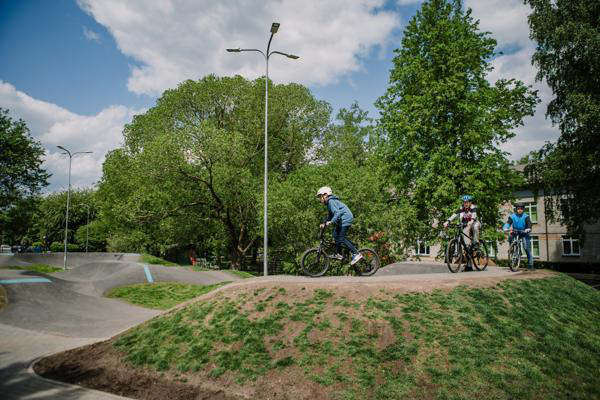

In [131]:
img_series = test_df.sample().iloc[0]
img_path = 'data/images/' + img_series['image_id']
img = load_image(img_path)
print(img_series)
img

In [132]:
pred_class,pred_idx,outputs = learn.predict(img_path)
pred_class

(#4) ['l0','l1','l11','l7']

In [133]:
file_names = listdir('data/images')
for i in test_df.index:
  if test_df.at[i, 'image_id'] in file_names:
    img_path = 'data/images/' + test_df.at[i, 'image_id']
    print(img_path)
    pred_class,pred_idx,outputs = learn.predict(img_path)
    print(pred_class)
    test_df.at[i, 'labels'] = ' '.join(pred_class)
  else:
    test_df.at[i, 'labels'] = ''
print(test_df)

data/images/img102.jpg


['l0']
data/images/img103.jpg


['l1', 'l2']
data/images/img11.jpg


['l1', 'l4']
data/images/img113.jpg


[]
data/images/img114.jpg


[]
data/images/img121.jpg


['l0', 'l1', 'l19', 'l22', 'l6']
data/images/img126.jpg


['l0', 'l6']
data/images/img131.jpg


[]
data/images/img136.jpg


[]
data/images/img137.jpg


['l1', 'l2']
data/images/img139.jpg


['l1']
data/images/img140.jpg


['l0', 'l1', 'l19', 'l22']
data/images/img15.jpg


['l53', 'l91']
data/images/img150.jpg


['l3']
data/images/img151.jpg


['l0', 'l1', 'l3', 'l5']
data/images/img152.jpg


['l3', 'l9']
data/images/img156.jpg


['l0', 'l7']
data/images/img161.jpg


['l0', 'l1', 'l6']
data/images/img166.jpg


['l0', 'l1']
data/images/img167.jpg


['l1']
data/images/img170.jpg


['l0', 'l1', 'l3', 'l7']
data/images/img173.jpg


['l0', 'l1', 'l4']
data/images/img176.jpg


['l0', 'l1', 'l4', 'l5']
data/images/img18.jpg


[]
data/images/img180.jpg


['l0']
data/images/img181.jpg


['l0', 'l1', 'l11', 'l7']
data/images/img182.jpg


['l0', 'l1']
data/images/img183.jpg


['l1']
data/images/img189.jpg


['l0', 'l1', 'l20', 'l38', 'l6']
data/images/img192.jpg


['l0', 'l10', 'l11']
data/images/img194.jpg


['l0', 'l10', 'l2']
data/images/img195.jpg


['l0']
data/images/img206.jpg


['l0', 'l1', 'l2']
data/images/img208.jpg


['l1']
data/images/img209.jpg


['l1', 'l10', 'l2']
data/images/img211.jpg


['l1', 'l2', 'l5', 'l7']
data/images/img212.jpg


['l1', 'l15', 'l2', 'l7']
data/images/img218.jpg


['l30', 'l70', 'l78', 'l8', 'l88']
data/images/img22.jpg


['l1', 'l18', 'l2', 'l21']
data/images/img221.jpg


[]
data/images/img228.jpg


['l4', 'l42', 'l69']
data/images/img230.jpg


['l1', 'l3', 'l4']
data/images/img231.jpg


['l4']
data/images/img234.jpg


['l1', 'l16', 'l4']
data/images/img238.jpg


['l0', 'l11']
data/images/img243.jpg


['l0', 'l1']
data/images/img247.jpg


['l1']
data/images/img248.jpg


[]
data/images/img249.jpg


[]
data/images/img250.jpg


[]
data/images/img251.jpg


[]
data/images/img252.jpg


['l5']
data/images/img257.jpg


[]
data/images/img259.jpg


['l0']
data/images/img262.jpg


[]
data/images/img265.jpg


[]
data/images/img266.jpg


['l1', 'l5']
data/images/img279.jpg


['l0']
data/images/img280.jpg


['l0']
data/images/img281.jpg


['l24']
data/images/img292.jpg


['l0', 'l3']
data/images/img296.jpg


['l24', 'l26', 'l28']
data/images/img3.jpg


['l3', 'l4', 'l7']
data/images/img300.jpg


['l28', 'l3', 'l48', 'l6']
data/images/img33.jpg


[]
data/images/img37.jpg


['l2']
data/images/img39.jpg


['l0']
data/images/img41.jpg


['l1', 'l2']
data/images/img42.jpg


[]
data/images/img43.jpg


[]
data/images/img48.jpg


['l0', 'l3', 'l45', 'l7', 'l9']
data/images/img49.jpg


['l0']
data/images/img5.jpg


['l0', 'l17', 'l4', 'l58', 'l63']
data/images/img57.jpg


[]
data/images/img59.jpg


['l0', 'l3', 'l7', 'l9']
data/images/img69.jpg


['l0', 'l1', 'l41']
data/images/img71.jpg


[]
data/images/img73.jpg


['l0']
data/images/img75.jpg


['l0']
data/images/img79.jpg


['l2']
data/images/img8.jpg


[]
data/images/img81.jpg


['l2']
data/images/img84.jpg


['l60']
data/images/img90.jpg


['l0']
data/images/img93.jpg


[]
data/images/img94.jpg


[]
      image_id labels
0   img102.jpg     l0
1   img103.jpg  l1 l2
2    img11.jpg  l1 l4
3   img113.jpg       
4   img114.jpg       
..         ...    ...
83   img81.jpg     l2
84   img84.jpg    l60
85   img90.jpg     l0
86   img93.jpg       
87   img94.jpg       

[88 rows x 2 columns]


In [134]:
test_df.to_csv('data/submission.csv', index = False)

In [135]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kristoferksr","key":"a4bd13e9e1309bcb31d2c742fde9a56c"}'}

In [136]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
- path is now set to: {/content}


In [137]:
!kaggle competitions submit -c tartu-object-detection-part-2 -f data/submission.csv -m "FastAI v2 submission"

100% 1.44k/1.44k [00:02<00:00, 691B/s]
Successfully submitted to Object recognition for The Image Bank of Tartu (2)